<a href="https://colab.research.google.com/github/anandpuntambekar/Cricket_Language_Model/blob/master/Cricketer_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Model for Cricketers using Transfer Learning


## Introduction

A language model is a model that learns to predict the next word of a sentence. To predict the next word of a sentence, you actually have to know quite a lot about English and quite a lot of world knowledge.

In the code we shall  develop a language Model sing text document associated with the following cricketers

- 'AB de Villiers'
- 'Brian Lara'
- 'Rahul Dravid'
- 'Rohit Sharma'
- 'Sachin Tendulkar'
- 'Shane Warne'

using **Transfer Learning**

#### Source of Data: https://www.kaggle.com/anandpuntambekar/cricketer-text-corpus-txt

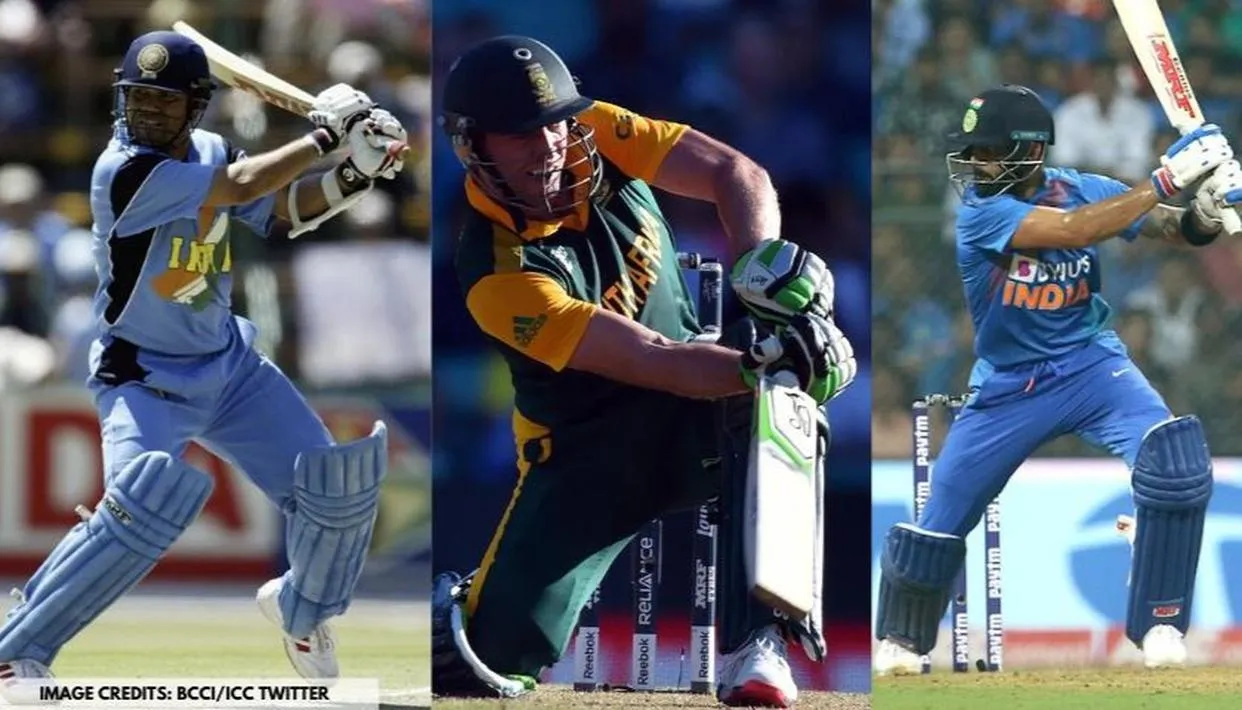

## Set up for Google Colab


To use Google Colab with FastAI v1, set Runtime->Set runtime type to GPU

We run the following code in Colab to install updated versions of PyTorch and Fastai. 

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
ERROR: Could not find a version that satisfies the requirement torch_nightly (from versions: none)
ERROR: No matching distribution found for torch_nightly
1.6.0+cu101
True
True


## Cleaning Input Data

Before uploading the data I took the liberty of remove spaces, tabs and hyper links in order to create a more efficient Language Model

## Upload the Text Data 

In [26]:
# Uncomment to upload text files
#from google.colab import files
#files.upload()

## Looking at Imported Data
No we will look at the Files imported:

In [3]:
import os
os.getcwd()

'/content'

In [4]:
import glob
os.chdir("/content")
for file in glob.glob("*.txt"):
    print(file)

Rahul Dravid.txt
ABD.txt
Rohit Sharma.txt
BRIAN_LARA.txt
Sachin Tendulkar.txt
Shane Warne.txt


In [5]:
with open("Sachin Tendulkar.txt") as myfile:
    head = [next(myfile) for x in range(5)]
print(head)

["\ufeff an ordinary piece to something truly extraordinary.    Who Will Win The World Cup? by Murari Gupta Dasa  AT THE HEIGHT OF Sachin Tendulkar's popularity a giant billboard proclaimed: Cricket is our religion and Sachin is our god.  That sums up the mood of \n", ' dismissed, the team is said to be all out and the two teams change roles.  A person who plays cricket is called cricketer.  Sachin Tendulkar hails from INDIA is the leading run-scorer and century maker in Test and one-day international cricket and called as \n', ' run of just 500 watches.  The other day I was watching the India – Australia one day match being played at Hyderabad.  Sachin Tendulkar was in full flow scoring runs and hitting the Australians all over.  I suddenly realized Hey boy!  This man is playing for \n', ' can he run so fast?  His hunger for the runs is simply astonishing!  There are many good things which have been said about Sachin Tendulkar and many more would be said.  There were times when he was

## Transfer Learning for NLP

For Neural Networks, weight matrices start out random. So if you start out with with some random parameters and try to train those parameters to learn, you literally have thousands of  ones and zeros to actually tell you the next word. 

That's clearly not enough information to learn how to speak English well enough to recognize the next word.

Sometimes that can be pretty nuanced. Particularly with cricket articals, journalist can often use sarcasm. 

So the trick, hopefully you can all guess, is to use **transfer learning**. 


We're going to start with pre-trained model that's been trained to do something different to what we're doing with it. And  then fine-tune that for Language Model for cricketers. We're going to start with a pre-trained model that's going to do something else. 

If we need to learn "how do you speak English?" we need a much bigger set of documents. 

## Wikitext 103

Wikitext 103 dataset which is simply a subset of the largest articles from Wikipedia with a little bit of pre-processing that's available for download. We're basically using a language model built on Wikipedia.

Just like a pre-trained ImageNet model for vision, there is a pre-trained Wikitext model for NLP . This Model understands a lot about language and a lot about what language describes. So then, we us the mdoel and perform transfer learning to create a new language model for cricketers.

In [6]:

#If somebody changes underlying library code while I'm running this, please reload it automatically
#If somebody asks to plot something, then please plot it here in this Jupyter Notebook
#We starts with the following three lines;

%reload_ext autoreload
%autoreload 2
%matplotlib inline


## Fast AI Text
The text module of the fastai library contains all the necessary functions to define a Dataset suitable for the various NLP (Natural Language Processing) tasks and quickly generate models you can use for them. Specifically:

text.transform contains all the scripts to preprocess your data, from raw text to token ids,
text.data contains the definition of TextDataBunch, which is the main class you'll need in NLP,
text.learner contains helper functions to quickly create a language model or an RNN classifier.

Some importnat NLP terms

1. Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. 

2. Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language



In [7]:
from fastai.text import *

In [8]:
# Batch Size:
# In order to avoid memory error( too many parameter updates for the amount of RAM ) - batch size needs to be fixed.
# bs: batch size (i.e. number of words processed at a time)

bs=48
path = "/content"

We're going to start with the language model. Now the good news is, we don't have to train the Wikitext 103 language model. It takes two or three days on a decent GPU, so not much point in you doing it. There's just no reason to start with random weights. It's always good to use transfer learning if you can.

So we're gonna start fine-tuning our Cricketers language model.

## Creation of Data Bunch

In order to create a model in fastai, we need to create a DataBunch object, in our case the data_lm variable 
In fastai, each thing that we model with, is going to be a DataBunch object. A DataBunch object contains 2 or 3 datasets:
Training data;
Validation data; and
Optionally test data.

Each of the above contains  texts and labels

While defining the DataBunch, we also need to create the Validation Data set to avoid over-fitting.

Over-fitting is a situation where the accuracy on the training data is high, but is on the lower end outside the training data. Over-fitting can be avoided by using a ‘validation set’.


In [9]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder() 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


Each document is a separate text file.

We randomly split it by 0.1 for validation set.


But How are we going to label it?

A language model kind of has its own labels. The text itself is labels so label for a language model (label_for_lm) does that for us.

And create a data bunch and save it. That takes a few minutes to tokenize and numericalize.

Since it takes some few minutes, we save it. Later on you can just load it. No need to run it again.

In [10]:
# Taking a look at data bunch
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"xxmaj november 2014 ? 1 ) xxmaj perth 2 ) \n at least a xxunk probability that xxunk xxunk have already xxunk because of man - made xxunk xxunk . xxmaj when xxmaj rahul xxmaj dravid was playing for xxmaj team xxmaj india , he hardly used to laugh . xxmaj he was considered as an extremely serious guy who xxunk very \n quite xxunk and does n't"
1,"xxunk ) , xxmaj australian xxmaj ricky xxmaj ponting ( 13,378 ) and xxmaj india 's xxmaj rahul xxmaj dravid ( 13,288 ) on the list of all - time run scorers . xxmaj kallis , now on xxunk runs , may struggle to overtake xxmaj tendulkar who is also \n xxmaj shane xxmaj warne as xxmaj mumbai could only manage 133 / 5 in their 20 overs ."
2,xxmaj tagged ' xxmaj india in xxmaj england 2011 ' xxmaj rahul xxmaj dravid back in the xxup odi squad xxmaj test specialist xxmaj rahul xxmaj dravid 's surprise recall to xxmaj india 's one - day squad after a gap of almost two \n car accident attorney today . xxmaj posts xxmaj tagged ' xxmaj india in xxmaj england 2011 ' xxmaj rahul xxmaj dravid back in the
3,"xxmaj former xxmaj india captain xxmaj rahul xxmaj dravid heaped praises on the recently retired xxmaj virender xxmaj sehwag and said the opener , who was once feared by new ball bowlers \n xxmaj october 8 , have expressed xxunk to xxmaj west xxmaj indies [ ... ] xxup london , xxmaj july 16 , 2014 ( xxup laureus ) – xxmaj legendary xxmaj indian cricketer xxmaj rahul xxmaj"
4,"virat xxmaj kohli became the highest xxmaj indian run - scorer in a xxmaj test series in xxmaj australia , surpassing xxmaj rahul xxmaj dravid , who scored 619 runs from eight innings on the 2003 - 04 tour . xxmaj captain xxmaj virat xxmaj kohli broke a xxunk of records while \n . xxmaj he is often seen in discussion with the captain , at times actively involved"


## Creation of Learner

We're going to create a language model learner with an RNN (a recurrent neural network). 

When we create a learner, you have to pass in two things:

The data: so here's our language model data

What pre-trained model we want to use: Wikitext 103 (will be downloaded from fastai just like ImageNet pre-trained models)

drop_mult sets the amount of dropout to avoid underfitting. Feel free to increase drop_mult to avoid over firring

Okay. so we've got a learner, we can lr_find and looks pretty standard:

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

**Learning rate**-
The learning rate basically says how quickly am I updating the parameters in my model parameters

Because we are trying to fine-tune things now, we can't use learning rate. So based on the learning rate finder, we will a rate well before it started getting worse. 

**Differential Learning Rate**
There's no point training all the layers at the same rate, because we know that the later layers worked just fine before when we were training much more quickly. So what we can actually do is we can pass a range of learning rates to learn.fit_one_cycle. :

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


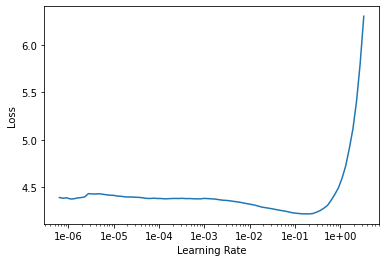

In [13]:
learn.recorder.plot()

Then we can fit one cycle.

In [14]:
learn.fit_one_cycle(1, 1e-1/3, moms=(0.8,0.7))

We basically found some coefficients and parameters that work pretty well . So if we want to start doing some more playing around and come back later, we probably should save those weights. You can just go learn.save and give it a name.

In [ ]:
learn.save('fit_head')
#learn.load('fit_head')

## Fine Tune The Model


Normally after we fine-tune the last layers, the next thing we do is we go unfreeze and train the whole thing. So here it is:

Unfreeze is the function that helps train the whole model. After calling unfreeze, we can again call fit_one_cycle.


The first part of the slice should be a value taken from your learning rate finder. This value is the rate at which the slope is steepest in the learning rate finder plot.

In [15]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-3,0.3e-2), moms=(0.8,0.7))

The accuracy, interesting. 0.3 means we're guessing the next word of the cricket article  correctly about a third of the time. That sounds like a pretty high number﹣the idea that you can actually guess the next word that often. So it's a good sign that my language model is doing pretty well. 

For more limited domain documents (like medical transcripts and legal transcripts), you'll often find this accuracy gets a lot higher. So sometimes this can be even 50% or more. But 0.3 or more is pretty good.

In [27]:
learn.save('fine_tuned')
#learn.load('fine_tuned')

## Testing the Model

In [22]:
TEXT = "Brian lara's performance "
N_WORDS = 30
N_SENTENCES = 3

You can now run learn.predict and pass in the start of a sentence, and it will try and finish off that sentence for you.

In [23]:
#Lowering temperature will make the texts less randomized.
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

Brian lara's performance  in Cricket Vs. South Africa T20 Trophy matches in Australia in November 2005 . This match was a star studded one
Brian lara's performance  in Test matches was not out and out of contention ; This is the story of Indian Cricket . This team is very good and
Brian lara's performance  on Sunday · Sachin 's Blasters vs Warne 's Warriors , will be interesting to see how n't Australians bowled the game on their


## Export the Model

The command below will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [24]:
learn.export()